# KenyaCoV vs deterministic model --- test and discrete time discussion

The purpose of this short note is to demonstrate that the stochastic Kenya ncov model behaves as expected compared to an ODE model. We initiate the model by including 100 infecteds amongst the urban population in each county. This effectively locks in epidemic growth from time zero and effectively eliminates stochastic effects, e.g. stochastic fade-out, stochastic invasion. We also have a brief look at the effect of time-step size on the typical duration of infection.

In this regime, the dynamics of the stochastic model **should** closely match the dynamics of the ODE model with the same underlying transmission structure because the population size is large in each county.

For simplicity there is no treatment and no external imports. No mortality and asymptomatics treated identically as symptomatics. Baseline parameter estimates R₀ = 2.2 and 3.6 mean infectious period.

We do this analysis for KenyaCoV model type 1: Spatial and Urban/Rural, and model type 2: Spatial and age structured.


Having defined the basic parameters we can solve and plot three different solutions:
* KenyaCoV with timestep dt = 0.1
* KenyaCoV with timestep dt = 1.
* KenyaCoV solved as the related deterministic model

### Model 2: Spatial and age-structured

In [1]:
push!(LOAD_PATH, "/Users/Sam/GitHub/KenyaCoV/src")
push!(LOAD_PATH, "/Users/Sam/GitHub/KenyaCoV/data")

using KenyaCoV, DifferentialEquations, Plots
using LinearAlgebra

┌ Info: Precompiling KenyaCoV [8af968fe-5b4e-4282-bf9e-761c92162993]
└ @ Base loading.jl:1273


In [17]:
# Load data for model --- and create an initially susceptible population
u0,P,transport_matrix = KenyaCoV.model_ingredients_from_data("./../data/data_for_age_structuredmodel.jld2",
                                                             "./../data/flight_numbers.csv",
                                                             "./../data/projected_global_prevelance.csv");
# #Change some parameters away from default

for (i,p) in enumerate(P.global_prev)
    P.global_prev[i] = 0.
end
P.ϵ = 1.
P.χ = ones(17)
#Rescale by maximum eigenvalue of the age mixing matrix rescaled by susceptibility

sus_matrix = repeat(P.χ,1,17)
R_A = P.ϵ*((1/P.σ₂) + (1/P.γ) )
R_M = (P.ϵ/P.σ₂) + (P.ϵ_D/P.γ)
R_V = (P.ϵ/P.σ₂) + (P.ϵ_V/P.τ)
R_vector = [(1-P.rel_detection_rate[a])*R_A + P.rel_detection_rate[a]*(1-P.hₐ[a])*R_M + P.rel_detection_rate[a]*P.hₐ[a]*R_V for a = 1:17]
inf_matrix = repeat(R_vector',17,1)

eigs, = eigen(sus_matrix.*P.M.*inf_matrix)
max_eigval = Real(eigs[end])


P.β = 2.5/max_eigval# Choosing the transmission rate that matches R₀ = 2.5
P.dt = 0.1; #<---- KenyaCoV is a discrete time simulation, timestep here is 1/10th of a day
# #Add 10 infecteds in 20-24 year old age category in every county
for i = 1:KenyaCoV.n_wa
    u0[i,5,3] += 10
end

In [16]:


# P.μ₁ = 0.
# pwd()

R_A = P.ϵ*((1/P.σ₂) + (1/P.γ) )
R_M = (P.ϵ/P.σ₂) + (P.ϵ_D/P.γ)
R_V = (P.ϵ/P.σ₂) + (P.ϵ_V/P.τ)
R_vector = [(1-P.rel_detection_rate[a])*R_A + P.rel_detection_rate[a]*(1-P.hₐ[a])*R_M + P.rel_detection_rate[a]*P.hₐ[a]*R_V for a = 1:17]
P.χ
max_eigval = Real(eigs[end])
P.β

0.026990016044658928

In [18]:
#Solve two different models

prob = KenyaCoV.create_KenyaCoV_non_neg_prob(u0,(0.,365.),P)
sol = solve(prob,FunctionMap(),dt = P.dt)

prob_ode = KenyaCoV.create_KenyaCoV_ode_prob(u0,(0.,365.),P)
sol_ode = solve(prob_ode,Tsit5());

UndefVarError: UndefVarError: PP_drivers not defined

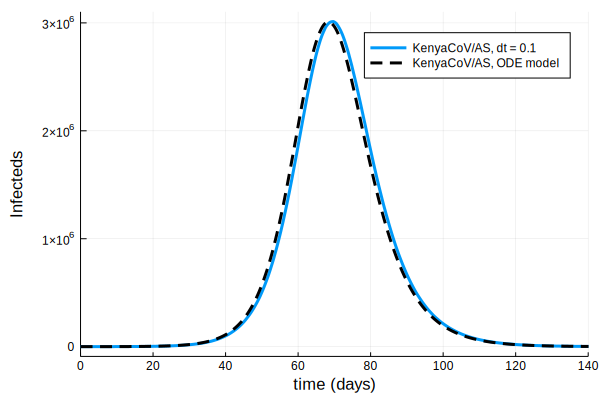

In [7]:
I = [sum(u[:,:,3:4]) for u in sol.u ]
I_ode = [sum(sol_ode(t)[:,:,3:4]) for t in sol.t] 

plt = plot(sol.t,I,lw = 3, lab = "KenyaCoV/AS, dt = $(P.dt)", xlims = (0.,140.), xlabel = "time (days)", ylabel = "Infecteds")
plot!(plt,sol.t,I_ode,lw = 3, ls = :dash,color = :black, lab = "KenyaCoV/AS, ODE model")

### Discrete time step effect

The discrete-time, stochastic model with larger timestep is different because the average time spent infected is typically larger.

Infected individuals are infectious for a period of either: dt, 2dt, 3dt, ... The average duration of infection is approximately,
$$
    \langle T_{inf} \rangle \approx dt/(1 - \exp(-\gamma dt)).
$$
This is a longer average duration of infection than $1/\gamma$ if $\gamma dt$ is not small. 

So big timesteps effectively boost $R_0$. This can be corrected for by choosing an *effective* recovery rate so that $R_0$ is preserved, or maintaining a small timestep. 

$$
    {\Delta t \over 1 - \exp(-\gamma_{eff} \Delta t) }  = {1 \over \gamma}\\
    \implies \gamma \Delta t  = 1 - \exp(-\gamma_{eff}\Delta t) \\
    \implies \exp(-\gamma_{eff}\Delta t) = 1 - \gamma \Delta t \\
    \implies \gamma_{eff} =  - {1 \over \Delta t}\ln ( 1- \gamma \Delta t) 
$$